In [1]:
import findspark
findspark.init()

In [2]:
from graphframes import *
from pyspark.sql.types import *
from pyspark.sql import functions as F

In [3]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('baza').getOrCreate()

In [5]:
nodes = spark.read.csv("/home/spark/lab04/task4/airports.csv", header=False)

In [6]:
nodes.columns

['_c0',
 '_c1',
 '_c2',
 '_c3',
 '_c4',
 '_c5',
 '_c6',
 '_c7',
 '_c8',
 '_c9',
 '_c10',
 '_c11',
 '_c12',
 '_c13']

In [7]:
cleaned_nodes = (nodes.select("_c1", "_c3", "_c4", "_c6", "_c7")
                 .filter("_c3 = 'United States'")
                 .withColumnRenamed("_c1", "name")
                 .withColumnRenamed("_c4", "id")
                 .withColumnRenamed("_c6", "latitude")
                 .withColumnRenamed("_c7", "longitude")
                 .drop("_c3"))

In [8]:
cleaned_nodes = cleaned_nodes[cleaned_nodes["id"] != "\\N"]

In [9]:
relationships = spark.read.csv("/home/spark/lab04/task4/188591317_T_ONTIME.csv", header=True)

In [10]:
cleaned_relationships = (relationships
                         .select("ORIGIN", "DEST", "FL_DATE", "DEP_DELAY", "ARR_DELAY",
                                 "DISTANCE", "TAIL_NUM", "FL_NUM", "CRS_DEP_TIME",
                                 "CRS_ARR_TIME", "UNIQUE_CARRIER")
                         .withColumnRenamed("ORIGIN", "src")
                         .withColumnRenamed("DEST", "dst")
                         .withColumnRenamed("DEP_DELAY", "deptDelay")
                         .withColumnRenamed("ARR_DELAY", "arrDelay")
                         .withColumnRenamed("TAIL_NUM", "tailNumber")
                         .withColumnRenamed("FL_NUM", "flightNumber")
                         .withColumnRenamed("FL_DATE", "date")
                         .withColumnRenamed("CRS_DEP_TIME", "time")
                         .withColumnRenamed("CRS_ARR_TIME", "arrivalTime")
                         .withColumnRenamed("DISTANCE", "distance")
                         .withColumnRenamed("UNIQUE_CARRIER", "airline")
                         .withColumn("deptDelay", F.col("deptDelay").cast(FloatType()))
                         .withColumn("arrDelay", F.col("arrDelay").cast(FloatType()))
                         .withColumn("time", F.col("time").cast(IntegerType()))
                         .withColumn("arrivalTime", F.col("arrivalTime").cast(IntegerType()))
                         )

In [11]:
g = GraphFrame(cleaned_nodes, cleaned_relationships)

In [12]:
airlines_reference = (spark.read.csv("/home/spark/lab04/task4/airlines.csv")
      .select("_c1", "_c3")
      .withColumnRenamed("_c1", "name")
      .withColumnRenamed("_c3", "code"))

In [13]:
airlines_reference = airlines_reference[airlines_reference["code"] != "null"]

In [14]:
df = spark.read.option("multiline", "true").json("/home/spark/lab04/task4/airlines.json")
dummyDf = spark.createDataFrame([("test", "test")], ["code", "name"])

In [16]:

for code in df.schema.fieldNames():
    tempDf = (df.withColumn("code", F.lit(code))
              .withColumn("name", df[code]))
    tdf = tempDf.select("code", "name")
    dummyDf = dummyDf.union(tdf)

In [17]:
airlines = (g.edges
 .groupBy("airline")
 .agg(F.count("airline").alias("flights"))
 .sort("flights", ascending=False))

full_name_airlines = (airlines_reference
                      .join(airlines, airlines.airline == airlines_reference.code)
                      .select("code", "name", "flights"))

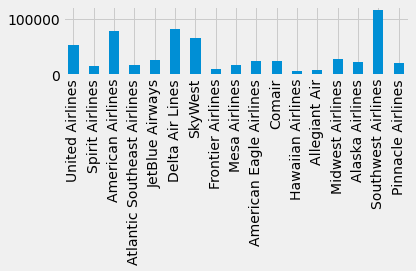

In [18]:
ax = (full_name_airlines.toPandas()
      .plot(kind='bar', x='name', y='flights', legend=None))

ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

In [19]:
# podpunkt 7 pominiety

In [20]:
airline_relationships = g.edges.filter("airline = 'DL'")
airline_graph = GraphFrame(g.vertices, airline_relationships)

In [21]:
 
clusters = airline_graph.labelPropagation(maxIter=10)
(clusters
  .sort("label")
  .groupby("label")
  .agg(F.collect_list("id").alias("airports"),
    F.count("id").alias("count"))
  .sort("count", ascending=False)
  .show(truncate=70, n=10))

+-------------+----------------------------------------------------------------------+-----+
|        label|                                                              airports|count|
+-------------+----------------------------------------------------------------------+-----+
|1606317768706|[IND, ORF, ATW, RIC, TRI, XNA, ECP, AVL, JAX, SYR, BHM, GSO, MEM, C...|   89|
|1219770712067|[GEG, SLC, DTW, LAS, SEA, BOS, MSN, SNA, JFK, TVC, LIH, JAC, FLL, M...|   53|
| 146028888064|                                                                 [CXY]|    1|
| 146028888066|                                                                 [RAC]|    1|
| 146028888065|                                                                 [JOT]|    1|
|   8589934592|                                                                 [4A7]|    1|
| 146028888067|                                                                 [RCA]|    1|
| 146028888068|                                                       

In [22]:
from bokeh.sampledata import us_states
from bokeh.plotting import *

In [23]:
us_states = us_states.data.copy()

In [24]:
 
del us_states["HI"]
del us_states["AK"]
# separate latitude and longitude points for the borders of the states.
state_xs = [us_states[code]["lons"] for code in us_states]
state_ys = [us_states[code]["lats"] for code in us_states]

In [25]:
# init figure
import csv
p = figure(title="Prezentacja lotnisk dla klastra 1606317768706",
toolbar_location="left", plot_width=1100, plot_height=700)
# Draw state lines
p.patches(state_xs, state_ys, fill_alpha=0.0, line_color="#884444", line_width=1.5)
x = []
y = []
with open("/home/spark/lab04/task4/latlongs-cluster1.csv", "r") as latlongs_file:
  reader = csv.reader(latlongs_file, delimiter=",")
  for row in reader:
    x.append(float(row[3]))
    y.append(float(row[2]))
    # The scatter markers
p.circle(x, y, size=6, color='navy', alpha=1)

GlyphRenderer(id='1042', ...)

In [26]:
output_file("cluster1.html")
# show results
show(p)